<style TYPE="text/css">
code.has-jax {font: inherit; font-size: 100%; background: inherit; border: inherit;}
</style>
<script type="text/x-mathjax-config">
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        skipTags: ['script', 'noscript', 'style', 'textarea', 'pre'] // removed 'code' entry
    }
});
MathJax.Hub.Queue(function() {
    var all = MathJax.Hub.getAllJax(), i;
    for(i = 0; i < all.length; i += 1) {
        all[i].SourceElement().parentNode.className += ' has-jax';
    }
});
</script>
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>



## Application of Reduced Gradient - Topology Optimization

<img src="tutorial_topopt/infill.gif" alt="Drawing" style="height: 600px;"/>

### Introduction

In this project, you will learn to implement an optimization algorithm for 
minimizing the compliance of a structure at its equilibrium state with respect to
its topology. The tutorial is based on Dr. Sigmund's topology optimization 
[code](http://www.topopt.dtu.dk/?q=node/751) 
and [paper](http://www.topopt.dtu.dk/files/TopOpt88.pdf). The template code is attached at the end of the tutorial.


### The compliance minimization problem
Topology optimization has been commonly used to design structures and materials with optimal mechanical, 
thermal, electromagnetic, acoustical, or other properties. 
The structure under design is segmented into $n$ finite elements, and a 
density value $x_i$ is assigned to each element $i \in \{1,2,...,n\}$: A higher density corresponds to a less porous material 
element and higher Yong's modulus. Reducing the density to zero is equivalent to creating a hole in the 
structure. Thus, the set of densities ${\bf x}=\{x_i\}$ can be used to represent the topology of the 
structure and is considered as the variables to be optimized. A common topology optimization problem is 
compliance minimization, where we seek the "stiffest" structure within a certain volume limit to withhold 
a particular load: 

$$ \min_{\bf x} \quad {\bf f} := {\bf d}^T {\bf K}({\bf x}) {\bf d} $$

$$ \text{subject to:} \quad {\bf h} := {\bf K}({\bf x}) {\bf d} = {\bf u}, $$

$$ \quad {\bf g} := V(\textbf{x}) \leq v,$$

$$ \textbf{x} \in [0,1]. $$

Here $V(\textbf{x})$ is the total volume; $v$ is an upper bound on volume; 
${\bf d} \in \mathbb{R}^{n_d\times 1}$ is the displacement of the structure under the load ${\bf u}$, 
where $n_d$ is the degrees of freedom (DOF) of the system (i.e., the number of x- and y-coordinates 
of nodes from the finite element model of the structure);
${\bf K(x)}$ is the global stiffness matrix for the structure.

${\bf K(x)}$ is indirectly influenced by the topology ${\bf x}$, through the element-wise stiffness matrix 

$${\bf K}_i = \bar{\bf K}_e E(x_i),$$

and the local-to-global assembly: 

$${\bf K(x)} = {\bf G}[{\bf K}_1,{\bf K}_2,...,{\bf K}_n],$$

where the matrix $\bar{\bf K}_e$ is predefined according to the finite element type (we use first-order 
quadrilateral elements throughout this tutorial) and the nodal displacements of the element (we use 
square elements with unit lengths throughout this tutorial), ${\bf G}$ is an assembly matrix, $E(x_i)$ is 
the element-wise Young's modulus defined as a function of the density $x_i$: 
$E(x_i) := \Delta E x_i^p + E_{\text{min}}$, where $p$ (the penalty parameter) is usually set to 3.
 This cubic relationship between the topology and the modulus 
is determined by the material constitutive models, and numerically, it 
also helps binarize the topologies, i.e., to push the optimal ${\bf x}_i$ to 1 or 0 (why?). 
The term $E_{\text{min}}$ is added to provide numerical stability.

### Design sensitivity analysis
This problem has both inequality and equality constraints. However, the inequality ones are only related
to the topology $\textbf{x}$, and are either 
linear ($V(\textbf{x}) \leq v$) or simple bounds ($\textbf{x} \in [0,1]$). We will 
show that these constraints can be easily handled.
The problem thus involves two sets of variables: We can consider $\textbf{x}$ as the **decision variables** 
and $\textbf{u}$ as the state variables that are governed by $\textbf{x}$ through the equality constraint
${\bf K}({\bf x}) {\bf d} = {\bf u}$.

The reduced gradient (often called design sensitivity) can be calculated as

$$\frac{df}{d{\bf x}} = \frac{\partial f}{\partial {\bf x}} - 
\frac{\partial f}{\partial {\bf u}}(\frac{\partial {\bf h}}{\partial {\bf u}})^{-1}
\frac{\partial {\bf h}}{\partial {\bf x}},$$

which leads to 

$$\frac{df}{d{\bf x}} = -{\bf u}^T \frac{\partial {\bf K}}{\partial {\bf x}}{\bf u}.$$

Recall the relation between ${\bf K}$ and ${\bf x}$, and notice that 

$${\bf u}^T {\bf K}{\bf u} = \sum_{i=1}^n {\bf u}^T_i{\bf K}_i{\bf u}_i,$$ 

i.e., the total compliance (strain energy) is the summation of element-wise compliance. 
We can further simplify the gradient as follows:

$$-{\bf u}^T \frac{\partial {\bf K}}{\partial {\bf x}}{\bf u} = - \frac{\partial {\bf u}^T{\bf K}{\bf u}}{\partial {\bf x}}$$

$$ = - \frac{\partial \sum_{i=1}^n {\bf u}^T_i{\bf K}_i{\bf u}_i}{\partial {\bf x}}$$

$$ = [..., - \frac{\partial {\bf u}^T_i{\bf K}_i{\bf u}_i}{\partial x_i}, ...] $$

$$ = [..., - {\bf u}^T_i \frac{\partial {\bf K}_i}{\partial x_i}{\bf u}_i, ...]$$

$$ = [..., - {\bf u}^T_i \frac{\partial \bar{\bf K}_e \Delta E x_i^3}{\partial x_i}{\bf u}_i, ...]$$

$$ = [..., - 3\Delta E x_i^2 {\bf u}^T_i \bar{\bf K}_e {\bf u}_i, ...]$$

### The algorithm
The pseudo code for compliance minimization is the following:


1. Problem setup (see details below)

2. Algorithm setup: $\epsilon = 0.001$ (or any small positive number), $k = 0$ (counter for the iteration),
$\Delta x = 1000$ (or any number larger than $\epsilon$)

3. While $norm(\Delta x) \leq \epsilon$, Do:
    
    3.1. Update the stiffness matrix ${\bf K}$ and the displacement (state) ${\bf u}$ (finite element analysis)
    
    3.2. Calculate element-wise compliance ${\bf u}^T_i \bar{\bf K}_e {\bf u}_i$
    
    3.3. Calculate partial derivatives 
    $$\frac{df}{dx_i} = - 3\Delta E x_i^2 {\bf u}^T_i \bar{\bf K}_e {\bf u}_i$$
    
    3.4. The gradient with respect to $g$ is a constant vector $[1,...,1]^T$
    
    3.5. Apply filter to $\frac{df}{d{\bf x}}$ (See discussion later)
    
    3.6. Update ${\bf x}$: $${\bf x}'_{k+1} = {\bf x}_{k} - \alpha_k (\frac{df}{d{\bf x}} + \mu {\bf 1})$$,
    where $\mu \geq 0$ is determined as in 3.7. To ensure that the gradient descent is successful, we will either set
    $\alpha_k$ to a small value, or truncate $\Delta x = - (\frac{df}{d{\bf x}} + \mu {\bf 1})$ within a range 
    (conceptually similar to the idea of trust region).
         
    3.7. Move ${\bf x}'_{k+1}$ back to the feasible domain:
    If ${\bf 1}^T{\bf x}_{k} < v$ and $-{\bf 1}^T\frac{df}{d{\bf x}}<0$, then ${\bf x}'_{k+1}$ satisfies $g$.
     with $\mu = 0$. If ${\bf x}'_{k+1}$ does not satisfy $g$, we will increase $\mu$ using bisection, i.e.,
     search in $[0,\mu_{max}]$ where $\mu_{max}$ is a large positive number. Also, we 
     will truncate ${\bf x}'_{k+1}$ between 0 and 1. 

    3.8. Update $norm(\Delta x)$, $k = k+1$

### Implementation details
Some details of the template code is explained as follows:

#### The numbering rule for elements and nodes
The template code assumes a rectangular design domain, where each element is modeled as a unit square. 
The numbering of elements and nodes are explained in the figure below.

<img src="tutorial_topopt/topopt881.png" alt="Drawing" style="height: 300px;"/> 


#### Input parameters
Inputs to the program are (1) the number of elements in the x and y directions (```nelx``` and ```nely```), 
(2) the volume fraction (```volfrac```, this is the number between 0 and 1 that specifies the
ratio between the volume of the target topology and the maximum volume $nelx \times nely$), (3) the penalty
parameter of the Young's Modulus model (```penal```, usually **=3**), and (4) the filter radius (```rmin```, 
usually **=3**).

#### Material properties
{% highlight MATLAB %}
%% MATERIAL PROPERTIES
E0 = 1;
Emin = 1e-9;
nu = 0.3;
{% endhighlight %}

Set the Young's Modulus (```E0```), and the Poisson's ratio (```nu```). Leave Emin as a small number.
  
#### Define loadings
{% highlight MATLAB %}
F = sparse(2,1,-1,2*(nely+1)*(nelx+1),1);
{% endhighlight %}

This line specifies the loading. Here ```F``` is a sparse column vector with ```2(nely+1)(nelx+1)``` elements.
```(2,1,-1,\cdots)``` specifies that there is a force of **-1** at the second row and first column
of the vector. According to the numbering convention of this code, this is to say that in the y direction
of the first node, there is a downward force of magnitude 1.

#### Define boundary conditions (Fixed DOFs)
{% highlight MATLAB %}
fixeddofs = union([1:2:2*(nely+1)],[2*(nelx+1)*(nely+1)]);
{% endhighlight %}

This line specifies the nodes with fixed DOFs. ```[1:2:2*(nely+1)]``` are x directions 
of all nodes to the left side of the structure, and ```2*(nelx+1)*(nely+1)``` is the y direction
of the last node (right bottom corner). See figure below:

<img src="tutorial_topopt/topopt882.png" alt="Drawing" style="height: 300px;"/> 

#### Filtering of sensitivity (gradient)
Pure gradient descent may result in a topology with checkerboard patterns.
While mathematically sound, such a solution can be infeasible from a manufacturing perspective or 
too expensive to realize (e.g., through additive manufacturing of porous structures). Therefore, 
a smoothed solution is often more preferred. 

---
### Using Topology Optimization to find the Optimum Topology for Some Given Loading Condition
---

We first use the code provided by Niels Aage to perform the topology optimization using their default setting, which are as follows:

* Number of element in x: 180
* Number of element in y: 60
* Volume Fraction: 0.4
* Penalty: 3.0
* Filter-radius: 5.4
* Filter Method: Density Based

We use MATLAB kernel and the original code before making any modification to see the result of the optimization. 

In [10]:
%%file top88.m
%plot inline

%%%% AN 88 LINE TOPOLOGY OPTIMIZATION CODE Nov, 2010 %%%%
function top88(nelx,nely,volfrac,penal,rmin,ft)
%% MATERIAL PROPERTIES
E0 = 1;
Emin = 1e-9;
nu = 0.3;
%% PREPARE FINITE ELEMENT ANALYSIS
A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12];
A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6];
B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4];
B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2];
KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11]);
nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx);
edofVec = reshape(2*nodenrs(1:end-1,1:end-1)+1,nelx*nely,1);
edofMat = repmat(edofVec,1,8)+repmat([0 1 2*nely+[2 3 0 1] -2 -1],nelx*nely,1);
iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);
jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);
% DEFINE LOADS AND SUPPORTS (HALF MBB-BEAM)
F = sparse(2,1,-1,2*(nely+1)*(nelx+1),1);
U = zeros(2*(nely+1)*(nelx+1),1);
fixeddofs = union([1:2:2*(nely+1)],[2*(nelx+1)*(nely+1)]);
alldofs = [1:2*(nely+1)*(nelx+1)];
freedofs = setdiff(alldofs,fixeddofs);
%% PREPARE FILTER
iH = ones(nelx*nely*(2*(ceil(rmin)-1)+1)^2,1);
jH = ones(size(iH));
sH = zeros(size(iH));
k = 0;
for i1 = 1:nelx
  for j1 = 1:nely
    e1 = (i1-1)*nely+j1;
    for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
      for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
        e2 = (i2-1)*nely+j2;
        k = k+1;
        iH(k) = e1;
        jH(k) = e2;
        sH(k) = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
      end
    end
  end
end
H = sparse(iH,jH,sH);
Hs = sum(H,2);
%% INITIALIZE ITERATION
x = repmat(volfrac,nely,nelx);
xPhys = x;
loop = 0;
change = 1;
%% START ITERATION
while change > 0.01
  loop = loop + 1;
  %% FE-ANALYSIS
  sK = reshape(KE(:)*(Emin+xPhys(:)'.^penal*(E0-Emin)),64*nelx*nely,1);
  K = sparse(iK,jK,sK); K = (K+K')/2;
  U(freedofs) = K(freedofs,freedofs)\F(freedofs);
  %% OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
  ce = reshape(sum((U(edofMat)*KE).*U(edofMat),2),nely,nelx);
  c = sum(sum((Emin+xPhys.^penal*(E0-Emin)).*ce));
  dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
  dv = ones(nely,nelx);
  %% FILTERING/MODIFICATION OF SENSITIVITIES
  if ft == 1
    dc(:) = H*(x(:).*dc(:))./Hs./max(1e-3,x(:));
  elseif ft == 2
    dc(:) = H*(dc(:)./Hs);
    dv(:) = H*(dv(:)./Hs);
  end
  %% OPTIMALITY CRITERIA UPDATE OF DESIGN VARIABLES AND PHYSICAL DENSITIES
  l1 = 0; l2 = 1e9; move = 0.2;
  while (l2-l1)/(l1+l2) > 1e-3
    lmid = 0.5*(l2+l1);
    xnew = max(0,max(x-move,min(1,min(x+move,x.*sqrt(-dc./dv/lmid)))));
    if ft == 1
      xPhys = xnew;
    elseif ft == 2
      xPhys(:) = (H*xnew(:))./Hs;
    end
    if sum(xPhys(:)) > volfrac*nelx*nely, l1 = lmid; else l2 = lmid; end
  end
  change = max(abs(xnew(:)-x(:)));
  x = xnew;
  %% PRINT RESULTS
  fprintf(' It.:%5i Obj.:%11.4f Vol.:%7.3f ch.:%7.3f\n',loop,c, ...
    mean(xPhys(:)),change);
  %% PLOT DENSITIES
  colormap(gray); imagesc(1-xPhys); caxis([0 1]); axis equal; axis off; drawnow;
end
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% This Matlab code was written by E. Andreassen, A. Clausen, M. Schevenels,%
% B. S. Lazarov and O. Sigmund,  Department of Solid  Mechanics,           %
%  Technical University of Denmark,                                        %
%  DK-2800 Lyngby, Denmark.                                                %
% Please sent your comments to: sigmund@fam.dtu.dk                         %
%                                                                          %
% The code is intended for educational purposes and theoretical details    %
% are discussed in the paper                                               %
% "Efficient topology optimization in MATLAB using 88 lines of code,       %
% E. Andreassen, A. Clausen, M. Schevenels,                                %
% B. S. Lazarov and O. Sigmund, Struct Multidisc Optim, 2010               %
% This version is based on earlier 99-line code                            %
% by Ole Sigmund (2001), Structural and Multidisciplinary Optimization,    %
% Vol 21, pp. 120--127.                                                    %
%                                                                          %
% The code as well as a postscript version of the paper can be             %
% downloaded from the web-site: http://www.topopt.dtu.dk                   %
%                                                                          %
% Disclaimer:                                                              %
% The authors reserves all rights but do not guaranty that the code is     %
% free from errors. Furthermore, we shall not be liable in any event       %
% caused by the use of the program.                                        %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Created file 'E:\PhD_Courses\Fall_2021\DesignOptimization2021Fall\Project\top88.m'.


 It.:    1 Obj.:  2027.5046 Vol.:  0.400 ch.:  0.200
 It.:    2 Obj.:  1116.2181 Vol.:  0.400 ch.:  0.200
 It.:    3 Obj.:   762.9094 Vol.:  0.400 ch.:  0.200
 It.:    4 Obj.:   600.6088 Vol.:  0.400 ch.:  0.200
 It.:    5 Obj.:   536.6777 Vol.:  0.400 ch.:  0.187
 It.:    6 Obj.:   505.3231 Vol.:  0.400 ch.:  0.200
 It.:    7 Obj.:   485.9178 Vol.:  0.400 ch.:  0.158
 It.:    8 Obj.:   465.8354 Vol.:  0.400 ch.:  0.200
 It.:    9 Obj.:   446.1834 Vol.:  0.400 ch.:  0.164
 It.:   10 Obj.:   427.8441 Vol.:  0.400 ch.:  0.200
 It.:   11 Obj.:   406.6264 Vol.:  0.400 ch.:  0.169
 It.:   12 Obj.:   385.0745 Vol.:  0.400 ch.:  0.200
 It.:   13 Obj.:   359.8834 Vol.:  0.400 ch.:  0.200
 It.:   14 Obj.:   335.4277 Vol.:  0.400 ch.:  0.200
 It.:   15 Obj.:   312.7668 Vol.:  0.400 ch.:  0.163
 It.:   16 Obj.:   296.5763 Vol.:  0.400 ch.:  0.162
 It.:   17 Obj.:   286.2479 Vol.:  0.400 ch.:  0.135
 It.:   18 Obj.:   280.0595 Vol.:  0.400 ch.:  0.123
 It.:   19 Obj.:   275.7058 Vol.:  0.400 ch.: 

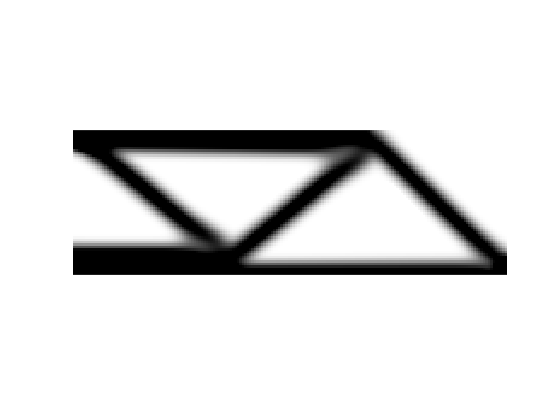

In [13]:
top88(180, 60, 0.4, 3, 5.4, 1)

#### This optimization resulted in the following structure. 

![topfinal](first.png)

The animation showing the progression in shown below: 

![anim2](default.gif)

We can further modify the boundary condition to see how the algorithm performs. We fix in the x and y-direction of the left side of the structure and keep everything free (imagine cantilever beam). We perform the following modifications to obtain the cantilever beam modeling. 

`F = sparse(2*(nely+1)*(nelx+1),1,-1,2*(nely+1)*(nelx+1),1);`

`fixeddofs = [1:2*nely+1];`

Then, we run the following: 

`top88(160,100,0.4,3,6,1)`

In [6]:
%%file top88.m

%%%% AN 88 LINE TOPOLOGY OPTIMIZATION CODE Nov, 2010 %%%%
function top88(nelx,nely,volfrac,penal,rmin,ft)
%% MATERIAL PROPERTIES
E0 = 1;
Emin = 1e-9;
nu = 0.3;
%% PREPARE FINITE ELEMENT ANALYSIS
A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12];
A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6];
B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4];
B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2];
KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11]);
nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx);
edofVec = reshape(2*nodenrs(1:end-1,1:end-1)+1,nelx*nely,1);
edofMat = repmat(edofVec,1,8)+repmat([0 1 2*nely+[2 3 0 1] -2 -1],nelx*nely,1);
iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);
jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);
% DEFINE LOADS AND SUPPORTS (HALF MBB-BEAM)
F = sparse(2*(nely+1)*(nelx+1),1,-1,2*(nely+1)*(nelx+1),1);
U = zeros(2*(nely+1)*(nelx+1),1);
%fixeddofs = union([1:2:2*(nely+1)],[2*(nelx+1)*(nely+1)]);
fixeddofs = [1:2*(nely+1)];
alldofs = [1:2*(nely+1)*(nelx+1)];
freedofs = setdiff(alldofs,fixeddofs);
%% PREPARE FILTER
iH = ones(nelx*nely*(2*(ceil(rmin)-1)+1)^2,1);
jH = ones(size(iH));
sH = zeros(size(iH));
k = 0;
for i1 = 1:nelx
  for j1 = 1:nely
    e1 = (i1-1)*nely+j1;
    for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
      for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
        e2 = (i2-1)*nely+j2;
        k = k+1;
        iH(k) = e1;
        jH(k) = e2;
        sH(k) = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
      end
    end
  end
end
H = sparse(iH,jH,sH);
Hs = sum(H,2);
%% INITIALIZE ITERATION
x = repmat(volfrac,nely,nelx);
xPhys = x;
loop = 0;
change = 1;
%% START ITERATION
while change > 0.01
  loop = loop + 1;
  %% FE-ANALYSIS
  sK = reshape(KE(:)*(Emin+xPhys(:)'.^penal*(E0-Emin)),64*nelx*nely,1);
  K = sparse(iK,jK,sK); K = (K+K')/2;
  U(freedofs) = K(freedofs,freedofs)\F(freedofs);
  %% OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
  ce = reshape(sum((U(edofMat)*KE).*U(edofMat),2),nely,nelx);
  c = sum(sum((Emin+xPhys.^penal*(E0-Emin)).*ce));
  dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
  dv = ones(nely,nelx);
  %% FILTERING/MODIFICATION OF SENSITIVITIES
  if ft == 1
    dc(:) = H*(x(:).*dc(:))./Hs./max(1e-3,x(:));
  elseif ft == 2
    dc(:) = H*(dc(:)./Hs);
    dv(:) = H*(dv(:)./Hs);
  end
  %% OPTIMALITY CRITERIA UPDATE OF DESIGN VARIABLES AND PHYSICAL DENSITIES
  l1 = 0; l2 = 1e9; move = 0.2;
  while (l2-l1)/(l1+l2) > 1e-3
    lmid = 0.5*(l2+l1);
    xnew = max(0,max(x-move,min(1,min(x+move,x.*sqrt(-dc./dv/lmid)))));
    if ft == 1
      xPhys = xnew;
    elseif ft == 2
      xPhys(:) = (H*xnew(:))./Hs;
    end
    if sum(xPhys(:)) > volfrac*nelx*nely, l1 = lmid; else l2 = lmid; end
  end
  change = max(abs(xnew(:)-x(:)));
  x = xnew;
  %% PRINT RESULTS
  fprintf(' It.:%5i Obj.:%11.4f Vol.:%7.3f ch.:%7.3f\n',loop,c, ...
    mean(xPhys(:)),change);
  %% PLOT DENSITIES
  colormap(gray); imagesc(1-xPhys); caxis([0 1]); axis equal; axis off; drawnow;
end
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% This Matlab code was written by E. Andreassen, A. Clausen, M. Schevenels,%
% B. S. Lazarov and O. Sigmund,  Department of Solid  Mechanics,           %
%  Technical University of Denmark,                                        %
%  DK-2800 Lyngby, Denmark.                                                %
% Please sent your comments to: sigmund@fam.dtu.dk                         %
%                                                                          %
% The code is intended for educational purposes and theoretical details    %
% are discussed in the paper                                               %
% "Efficient topology optimization in MATLAB using 88 lines of code,       %
% E. Andreassen, A. Clausen, M. Schevenels,                                %
% B. S. Lazarov and O. Sigmund, Struct Multidisc Optim, 2010               %
% This version is based on earlier 99-line code                            %
% by Ole Sigmund (2001), Structural and Multidisciplinary Optimization,    %
% Vol 21, pp. 120--127.                                                    %
%                                                                          %
% The code as well as a postscript version of the paper can be             %
% downloaded from the web-site: http://www.topopt.dtu.dk                   %
%                                                                          %
% Disclaimer:                                                              %
% The authors reserves all rights but do not guaranty that the code is     %
% free from errors. Furthermore, we shall not be liable in any event       %
% caused by the use of the program.                                        %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



Created file 'E:\PhD_Courses\Fall_2021\DesignOptimization2021Fall\Project\top88.m'.


 It.:    1 Obj.:   483.8669 Vol.:  0.400 ch.:  0.200
 It.:    2 Obj.:   270.6992 Vol.:  0.400 ch.:  0.200
 It.:    3 Obj.:   185.9530 Vol.:  0.400 ch.:  0.200
 It.:    4 Obj.:   145.5753 Vol.:  0.400 ch.:  0.200
 It.:    5 Obj.:   128.7975 Vol.:  0.400 ch.:  0.200
 It.:    6 Obj.:   114.3709 Vol.:  0.400 ch.:  0.200
 It.:    7 Obj.:   102.8687 Vol.:  0.400 ch.:  0.200
 It.:    8 Obj.:    92.4505 Vol.:  0.400 ch.:  0.200
 It.:    9 Obj.:    84.2798 Vol.:  0.400 ch.:  0.200
 It.:   10 Obj.:    78.0293 Vol.:  0.400 ch.:  0.200
 It.:   11 Obj.:    73.0313 Vol.:  0.400 ch.:  0.200
 It.:   12 Obj.:    68.9151 Vol.:  0.400 ch.:  0.200
 It.:   13 Obj.:    65.5858 Vol.:  0.400 ch.:  0.200
 It.:   14 Obj.:    63.5255 Vol.:  0.400 ch.:  0.200
 It.:   15 Obj.:    62.6404 Vol.:  0.400 ch.:  0.124
 It.:   16 Obj.:    62.3184 Vol.:  0.400 ch.:  0.086
 It.:   17 Obj.:    62.2330 Vol.:  0.400 ch.:  0.065
 It.:   18 Obj.:    62.1385 Vol.:  0.400 ch.:  0.052
 It.:   19 Obj.:    62.0787 Vol.:  0.400 ch.: 

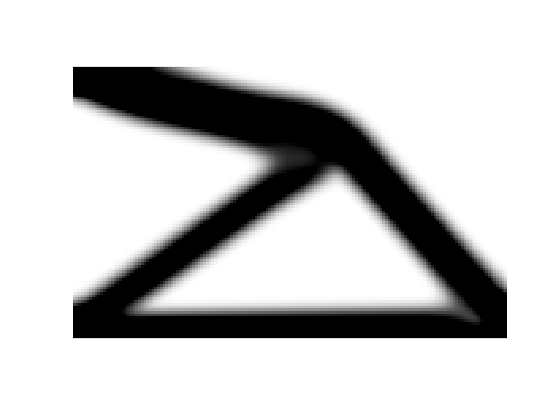

In [7]:
top88(160,100,0.4,3,6,1)

The optimization resulted in the final geometry as shown above. The animation showing the process is shown below. 

![anim](cantilever.gif)